### Общий план:
- Заполнить пропуски в данных диагностики
- Агрегировать результаты диагностики по каждому юзеру
- Выделить фичи из текста
- Агрегировать фичи по юзеру
- Объединить датасеты
- Построить матрицу корреляций по полученному датасету
- Наиболее удачные, яркие корреляции рассмотреть подробнее
- __Построить модель для прогнозирования результата диагностики по фичам текста__

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import *

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Загружаем данные
Агрегированные результаты диагностик + агрегаты текстовых фич

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape, test.shape

((1417, 336), (110, 336))

In [15]:
def plot_results(true, pred, ttl, draw=False):
    plt.figure(figsize=(5, 5))
    plt.scatter(true, pred, alpha = 0.7)

    max_value = max([true.max(),pred.max()])
    plt.plot([0, max_value], [0, max_value], c = 'r')
    plt.title(ttl)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend(['True=Predicted','Object'])
    plt.grid()
    print('MAE модели: ', mean_absolute_error(true, pred))
    print('MSE модели: ', mean_squared_error(true, pred))
    if draw:
        plt.savefig('{}.png'.format(ttl), bbox_inches='tight')
    plt.show()

    
def predict_motivation(target_name):
    # возьмем только сэмплы, по оторым есть оценки для данного вида диагностики 
    X_train = train[train[[target_name]+synth][target_name]!=0][synth]
    y_train = train[train[[target_name]+synth][target_name]!=0][target_name]

    X_test = test[test[[target_name]+synth][target_name]!=0][synth]
    y_test = test[test[[target_name]+synth][target_name]!=0][target_name]
    
    model = XGBRegressor(n_estimators=150,max_depth=25,random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('КАЧЕСТВО ПРОГНОЗА ML МОДЕЛИ:')
    plot_results(y_test, y_pred, target_name)
    print(pd.DataFrame({'feature':X_train.columns, 
                  'importance':model.feature_importances_}).sort_values(by=['importance'],ascending=False))
    print("*******************************************************")
    X_test['const'] = 1
    print('КАЧЕСТВО ПРОГНОЗА КОНСТАНТОЙ:')
    plot_results(y_test, X_test['const'], 'Constant '+target_name)

In [16]:
# определяем синтетические фичи, на которых будем обучаться
synth = ['sentiment_negative', 'sentiment_neutral','sentiment_positive', 'sentiment_skip', 
         'sentiment_speech','answer_len', 'upper_case_word_count', 'punctuation_count', 'ner']

## Модель регрессии для теста "Мотивации", обученная на текстовых признаках.

- Для оценки качества работы алгоритма используются средняя абсолютная ошибка (Mean Absolute Error) и среднеквадратичная ошибка (Mean Squared Error).
- Для сравнения приводятся метрики при прогнозировании показателя мотивации константой = 1.

### Прогноз мотиватора “избегание негатива, размеренность, безопасность”

- В топ по значимости выходят такие признаки, как "sentiment_speech" (вежливые обороты, пожелания наилучшего и т.п.) "sentiment_positive" (позитивная тональность текста). Кажется логичным, что у людей, использующих в основном положительный тон при написании рефлексии повышено значение мотиватора "избегание негатива, размеренность, безопасность".

КАЧЕСТВО ПРОГНОЗА ML МОДЕЛИ:
MAE модели:  1.6229658833256475
MSE модели:  4.573497943463759


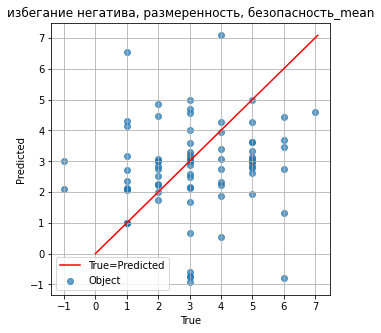

                 feature  importance
4       sentiment_speech    0.675332
2     sentiment_positive    0.108441
1      sentiment_neutral    0.047807
8                    ner    0.043219
7      punctuation_count    0.040957
5             answer_len    0.039348
6  upper_case_word_count    0.037266
0     sentiment_negative    0.007290
3         sentiment_skip    0.000340
*******************************************************
КАЧЕСТВО ПРОГНОЗА КОНСТАНТОЙ:
MAE модели:  2.2962962962962963
MSE модели:  7.604938271604938


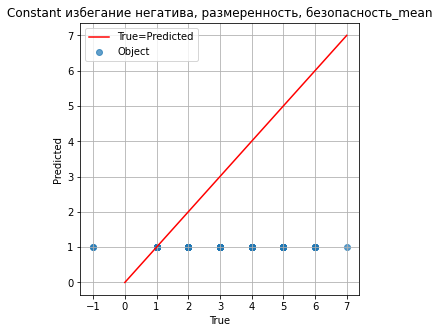

In [20]:
predict_motivation('избегание негатива, размеренность, безопасность_mean')

### Прогноз мотиватора “преодоление сложностей, препятствий”
- В топ по значимости выходит "snetiment_positive" (положительная тональность текста). Вероятно, у людей, оставляющих положительные комментарии в рефлексии, повышен показатель данного мотиватора.  

КАЧЕСТВО ПРОГНОЗА ML МОДЕЛИ:
MAE модели:  2.1804077843340433
MSE модели:  7.742697751405227


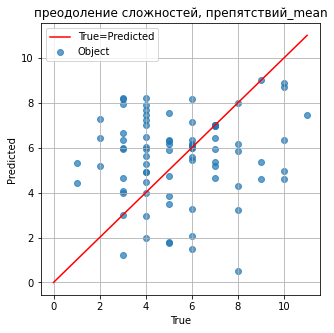

                 feature  importance
2     sentiment_positive    0.553579
3         sentiment_skip    0.120348
8                    ner    0.089706
6  upper_case_word_count    0.064441
4       sentiment_speech    0.060909
7      punctuation_count    0.050877
5             answer_len    0.034599
1      sentiment_neutral    0.023644
0     sentiment_negative    0.001897
*******************************************************
КАЧЕСТВО ПРОГНОЗА КОНСТАНТОЙ:
MAE модели:  4.439024390243903
MSE модели:  24.878048780487806


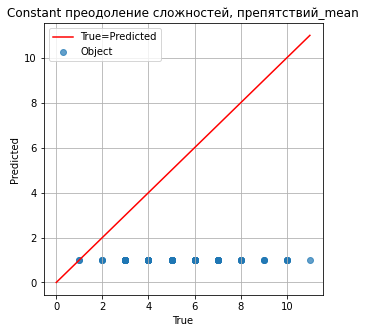

In [22]:
predict_motivation('преодоление сложностей, препятствий_mean')

### Прогноз мотиватора “осмысленность деятельности, собственная значимость”

КАЧЕСТВО ПРОГНОЗА ML МОДЕЛИ:
MAE модели:  1.0457501635831945
MSE модели:  1.8011755048658522


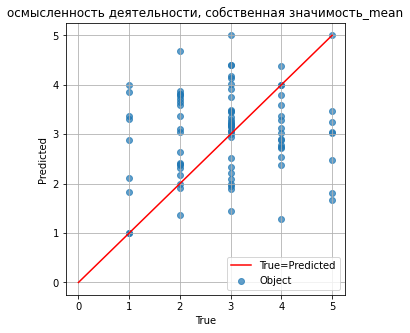

                 feature  importance
7      punctuation_count    0.165289
8                    ner    0.144636
4       sentiment_speech    0.128881
3         sentiment_skip    0.125508
6  upper_case_word_count    0.111084
5             answer_len    0.108256
1      sentiment_neutral    0.081728
2     sentiment_positive    0.070386
0     sentiment_negative    0.064232
*******************************************************
КАЧЕСТВО ПРОГНОЗА КОНСТАНТОЙ:
MAE модели:  1.9411764705882353
MSE модели:  5.0


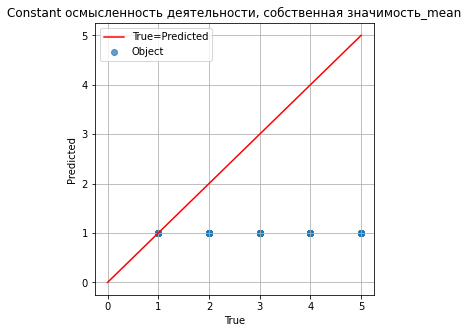

In [17]:
predict_motivation('осмысленность деятельности, собственная значимость_mean')

### Прогноз мотиватора “социальный элемент, дружба, влияние, конкуренция”

КАЧЕСТВО ПРОГНОЗА ML МОДЕЛИ:
MAE модели:  1.2892731975106633
MSE модели:  2.7906210803874085


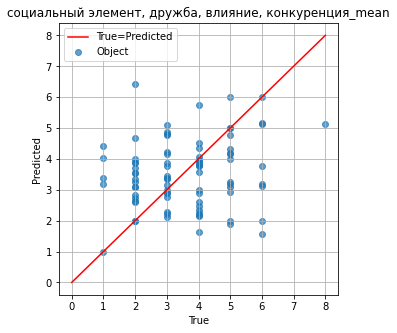

                 feature  importance
4       sentiment_speech    0.187894
0     sentiment_negative    0.184452
2     sentiment_positive    0.153336
8                    ner    0.149194
7      punctuation_count    0.106726
6  upper_case_word_count    0.088028
5             answer_len    0.073255
1      sentiment_neutral    0.057116
3         sentiment_skip    0.000000
*******************************************************
КАЧЕСТВО ПРОГНОЗА КОНСТАНТОЙ:
MAE модели:  2.5764705882352943
MSE модели:  8.788235294117648


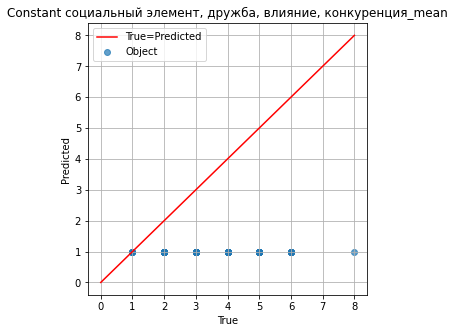

In [18]:
predict_motivation('социальный элемент, дружба, влияние, конкуренция_mean')

### Прогноз мотиватора “самосовершенствование, работа над собой, труд”

КАЧЕСТВО ПРОГНОЗА ML МОДЕЛИ:
MAE модели:  2.160438251931493
MSE модели:  7.520183860521654


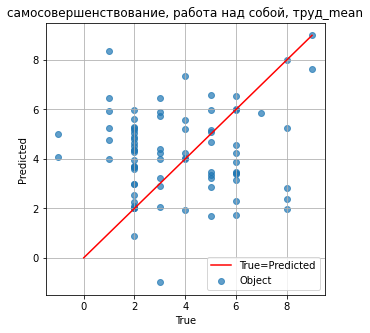

                 feature  importance
3         sentiment_skip    0.327634
2     sentiment_positive    0.293155
8                    ner    0.085195
5             answer_len    0.056780
0     sentiment_negative    0.055271
6  upper_case_word_count    0.054513
4       sentiment_speech    0.050788
7      punctuation_count    0.049693
1      sentiment_neutral    0.026971
*******************************************************
КАЧЕСТВО ПРОГНОЗА КОНСТАНТОЙ:
MAE модели:  2.792682926829268
MSE модели:  12.28048780487805


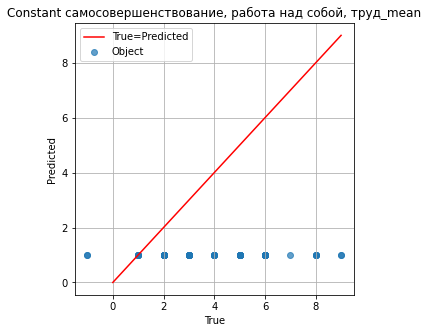

In [21]:
predict_motivation('самосовершенствование, работа над собой, труд_mean')

### Прогноз мотиватора “достижение, стремление к лидерству”

КАЧЕСТВО ПРОГНОЗА ML МОДЕЛИ:
MAE модели:  1.734364970230762
MSE модели:  4.921211794229905


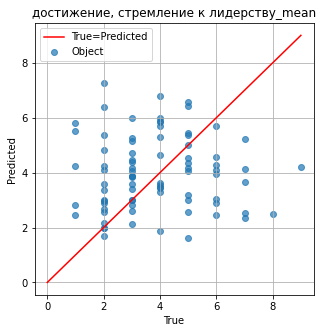

                 feature  importance
3         sentiment_skip    0.220423
2     sentiment_positive    0.185133
8                    ner    0.137390
0     sentiment_negative    0.121595
7      punctuation_count    0.101572
6  upper_case_word_count    0.093364
5             answer_len    0.065100
1      sentiment_neutral    0.048980
4       sentiment_speech    0.026443
*******************************************************
КАЧЕСТВО ПРОГНОЗА КОНСТАНТОЙ:
MAE модели:  2.8271604938271606
MSE модели:  11.197530864197532


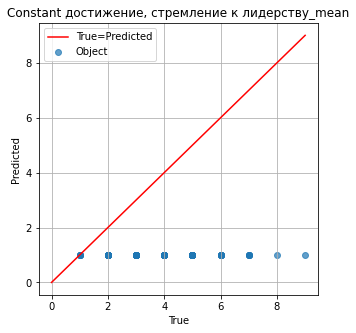

In [23]:
predict_motivation('достижение, стремление к лидерству_mean')